# Загрузка данных

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, BaggingClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap

from sklearn.ensemble import GradientBoostingClassifier
import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostClassifier


## Бинарная переменная

In [5]:
data = pd.read_csv('RedWineQuality.csv', sep=';')

# Создание бинарной целевой переменной
data['quality_bin'] = (data['quality'] >= 6).astype(int)

# Выбор признаков и целевой переменной
features = ['volatile acidity', 'density', 'alcohol', 'sulphates']
#X = data[features]
X = data.drop(['quality_bin', 'quality'], axis=1)
y = data['quality_bin']


In [6]:
# Загрузка данных
if False:
    data = pd.read_csv('Never Trust Summary Statistics.tsv', delimiter="\t")

    # Создание бинарной целевой переменной
    data.loc[ data["dataset"] != 'bullseye', "dataset"] = 0
    data.loc[ data["dataset"] == 'bullseye', "dataset"] = 1
    data["dataset"] = data["dataset"].astype(int)

    # Выбор признаков и целевой переменной
    features = ['x', 'y']
    X = data[features]
    y = data['dataset']


# Разделение данных: 60% train, 20% validation, 20% test

In [7]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [17]:
# Масштабирование данных
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Обучение моделей

In [22]:
# GradientBoosting
from sklearn.ensemble import GradientBoostingClassifier
gb = GradientBoostingClassifier(
    n_estimators=50000, 
    learning_rate=0.1, 
    validation_fraction=0.2, 
    n_iter_no_change=10
)
gb.fit(X_train, y_train)

# LightGBM
import lightgbm as lgb
lgb_model = lgb.LGBMClassifier(
    n_estimators=5000, 
    learning_rate=0.05,
    num_leaves=31, 
    max_depth=30
)
lgb_model.fit(
    X_train, y_train, 
    eval_set=[(X_val, y_val)], callbacks=[lgb.early_stopping(10)]
)

# XGBoost
import xgboost as xgb
xgb_model = xgb.XGBClassifier(
    n_estimators=5000, 
    learning_rate=0.1,
    max_depth=20, 
    eval_metric='logloss'
)
xgb_model.fit(
    X_train, y_train, 
    eval_set=[(X_val, y_val)]
) #,  early_stopping_rounds=10)

# CatBoost
from catboost import CatBoostClassifier
cb_model = CatBoostClassifier(
    iterations=5000, 
    learning_rate=0.05,
    depth=16, 
    verbose=0
)
cb_model.fit(
    X_train, y_train, 
    eval_set=(X_val, y_val)
) #, early_stopping_rounds=10)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 518, number of negative: 441
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000156 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 958
[LightGBM] [Info] Number of data points in the train set: 959, number of used features: 11
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.540146 -> initscore=0.160930
[LightGBM] [Info] Start training from score 0.160930
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[111]	valid_0's binary_logloss: 0.442368
[0]	validation_0-logloss:0.66204
[1]	validation_0-logloss:0.63544
[2]	validation_0-logloss:0.61430
[3]	validation_0-logloss:0.59494
[4]	validation_0-logloss:0.57889
[5]	validation_0-logloss:0.56441
[6]	validation_0-log

# Предсказание

In [25]:
gb_pred = gb.predict(X_test)
lgb_pred = lgb_model.predict(X_test)
xgb_pred = xgb_model.predict(X_test)
cb_pred = cb_model.predict(X_test)

# Вычисление метрик и построение матриц ошибок

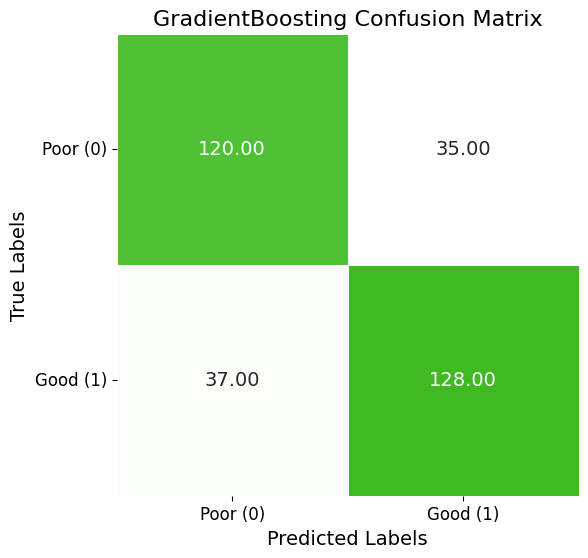


GradientBoosting Confusion Matrix (Counts):
[[120  35]
 [ 37 128]]


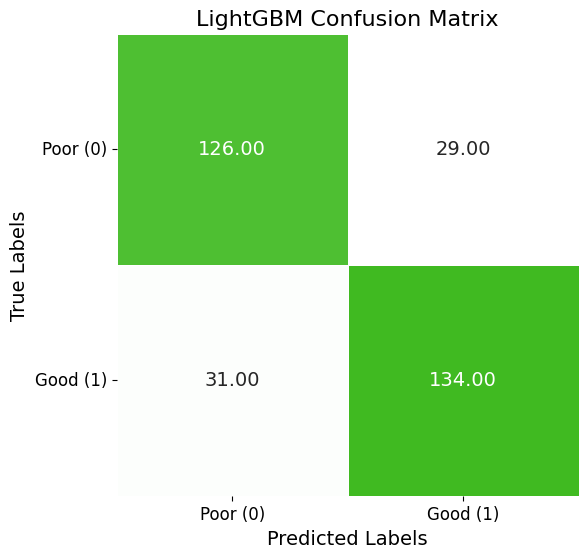


LightGBM Confusion Matrix (Counts):
[[126  29]
 [ 31 134]]


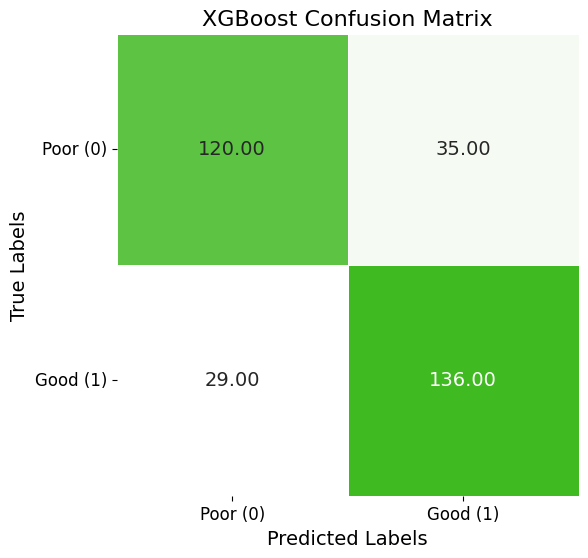


XGBoost Confusion Matrix (Counts):
[[120  35]
 [ 29 136]]


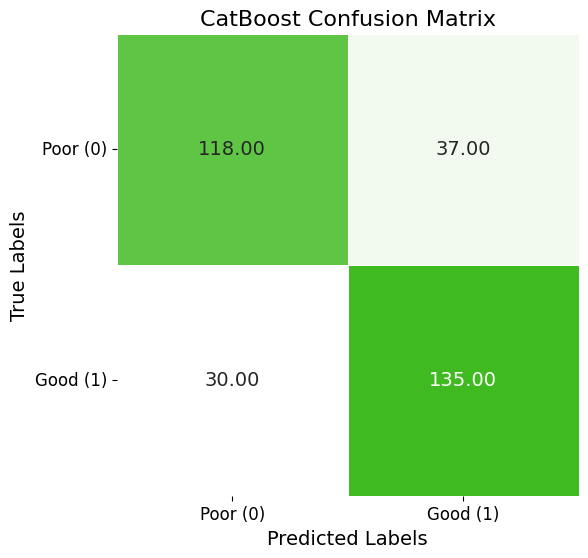


CatBoost Confusion Matrix (Counts):
[[118  37]
 [ 30 135]]


In [30]:
# Собираем модели в словарь
models = {
    'GradientBoosting': gb,
    'LightGBM': lgb_model,
    'XGBoost': xgb_model,
    'CatBoost': cb_model
}

corp_col = '#40ba21'

# Функция для вычисления метрик
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    metrics = {
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1': f1_score(y_test, y_pred),
        'AUC': roc_auc_score(y_test, y_pred)
    }
    cm = confusion_matrix(y_test, y_pred)
    return metrics, cm

# Создаем градиентную цветовую карту
def create_gradient_cmap(hex_color):
    rgb_color = tuple(int(hex_color[i:i+2], 16)/255 for i in (1, 3, 5))
    return LinearSegmentedColormap.from_list("", [(1, 1, 1), rgb_color])

# Оценка моделей на тестовых данных
results = {}
c_map = create_gradient_cmap(corp_col)

for name, model in models.items():
    # Вычисляем метрики
    results[name], cm = evaluate_model(model, X_val, y_val)
    
    # Нормализуем матрицу для лучшей визуализации
    cm_normalized = cm#.astype('float')# / cm.sum(axis=1)[:, np.newaxis]
    
    # Строим матрицу ошибок
    plt.figure(figsize=(8, 6))
    sns.heatmap(
        cm_normalized, 
        annot=True, 
        fmt=".2f", 
        cmap=c_map, 
        linewidths=.5, 
        square=True,
        cbar=False,
        annot_kws={"size": 14}
    )
    plt.title(f'{name} Confusion Matrix', fontsize=16)
    plt.xlabel('Predicted Labels', fontsize=14)
    plt.ylabel('True Labels', fontsize=14)
    plt.xticks([0.5, 1.5], ['Poor (0)', 'Good (1)'], fontsize=12)
    plt.yticks([0.5, 1.5], ['Poor (0)', 'Good (1)'], fontsize=12, rotation=0)
    plt.show()
    
    # Выводим числовые значения матрицы
    print(f"\n{name} Confusion Matrix (Counts):")
    print(cm)

# Добавление одиночных моделей для сравнения

In [ ]:
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier(max_depth=5, random_state=42)
dt.fit(X_train, y_train)
results['DecisionTree'], _ = evaluate_model(dt, X_val, y_val)

lr = LogisticRegression(max_iter=1000, random_state=42)
lr.fit(X_train_scaled, y_train)
results['LogisticRegression'], _ = evaluate_model(lr, X_val_scaled, y_val)

# Создаем сводную таблицу
final_results = pd.DataFrame({
    'Model': list(results.keys()),
    'Accuracy': [results[m]['Accuracy'] for m in results],
    'Precision': [results[m]['Precision'] for m in results],
    'Recall': [results[m]['Recall'] for m in results],
    'F1': [results[m]['F1'] for m in results],
    'AUC': [results[m]['AUC'] for m in results]
}).sort_values('F1', ascending=False)

print("\n" + "="*70)
print("Сравнение всех моделей:")
print("="*70)
print(final_results.round(3))


Сравнение всех моделей:
                Model  Accuracy  Precision  Recall     F1    AUC
1            LightGBM     0.812      0.822   0.812  0.817  0.813
2             XGBoost     0.800      0.795   0.824  0.810  0.799
3            CatBoost     0.791      0.785   0.818  0.801  0.790
0    GradientBoosting     0.775      0.785   0.776  0.780  0.775
4        DecisionTree     0.750      0.754   0.764  0.759  0.750
5  LogisticRegression     0.731      0.752   0.715  0.733  0.732


## Выводы. 
1. В целом все 4 градиентных метода показали очень близкие значения метрик, на первом месте LightGBM за счёт очень большого количества итераций, что стало возможным благодаря высокой вычислительной эффективности этого метода.
2. Градиентные ансамблевые методы дали значимый прирост качества классификации по сравнению с одиночными классификаторами на валидационных данных: качество модели (AUC) выросло до уровней 0.78-0.81 по сравнению с одиночными классификаторами (AUC = 0.73-0.75).